<a href="https://colab.research.google.com/github/254-KIPSANG/EDA--PYTHON/blob/main/Crypto_Financial_App_Security.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import wordcloud
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import re
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
!pip install -q google-play-scraper
import pandas as pd
from google_play_scraper import reviews
from google_play_scraper import Sort


In [23]:
import pandas as pd
from reviews import reviews, Sort  # Assuming you have imported the necessary libraries

# Define the apps dictionary and other constants
apps = {
    "Fidelity Crypto": "com.fidelity.android",
    "Crypto.com": "co.mona.android",
    "Robinhood Crypto": "com.robinhood.android",
    "Coinbase" : "com.coinbase.android"
}

SORT = Sort.NEWEST
N_REVIEWS = 10000
reviews_dict = {k: {} for k in apps}

# Scraping reviews
for app in apps.keys():
    # Retrieve reviews for each app
    reviews_dict[app], _ = reviews(
        apps[app],
        lang='en',
        country='us',
        sort=SORT,
        count=N_REVIEWS,
        filter_score_with=None
    )
    # Ensure the correct number of reviews are retrieved
    assert len(reviews_dict[app]) == N_REVIEWS

# Saving reviews
df = pd.DataFrame()
for app in apps.keys():
    SAVE_DIR = app + ".csv"
    # Create DataFrame with review data
    temp_df = pd.DataFrame(
        reviews_dict[app],
        columns=["reviewId", "content", "score", "userName", "userImage", "thumbsUpCount", "reviewCreatedVersion", "at", "replyContent"]
    )
    # Add app name to identify reviews by app
    temp_df["app"] = app
    # Add review_length column to calculate the length of each review
    temp_df["review_length"] = temp_df["content"].apply(lambda x: len(x))
    # Save DataFrame to CSV file
    temp_df.to_csv(SAVE_DIR, index=False)
    # Concatenate temporary DataFrame with main DataFrame
    df = pd.concat((df, temp_df))

# Save combined DataFrame to CSV file
df.to_csv("all_combined.csv", index=False)
print("DONE :) ")
# Display the first few rows of the combined DataFrame
df.head()


DONE :) 


,reviewId,content,score,userName,userImage,thumbsUpCount,reviewCreatedVersion,at,replyContent,app,review_length
0,1e82b295-0b13-426e-b9e3-a0b26419b242,Very easy to use the sire,5,David Beil,https://play-lh.googleusercontent.com/a-/ALV-U...,0,None,2024-02-07 15:50:15,"Hi David, thanks for taking the time to leave ...",Fidelity Crypto,25
1,30313959-78a2-41e1-a20d-8c93dd74b6a9,Top tier,5,Paula Grooveparlortv Harris,https://play-lh.googleusercontent.com/a-/ALV-U...,0,3.91,2024-02-07 15:44:55,Hi Paula. Thanks for taking the time to leave ...,Fidelity Crypto,8
2,b9b1ab64-e460-46b5-aa11-1864fb39da85,Spent almost hour with technical support with ...,1,Roger Duvall,https://play-lh.googleusercontent.com/a-/ALV-U...,0,3.91,2024-02-07 15:07:39,"Hi, Roger; thank you for taking the time to le...",Fidelity Crypto,146
3,11432b71-c238-403e-aebd-277bb453bb92,Works good,4,michael pietschker,https://play-lh.googleusercontent.com/a/ACg8oc...,0,3.90,2024-02-07 14:55:29,Hi Michael. Thanks for taking the time to leav...,Fidelity Crypto,10
4,3c3370bf-6f4a-4a86-a3c9-40c281e43e2b,"Easy to use, and works consistently.",5,Thomas Anderson,https://play-lh.googleusercontent.com/a-/ALV-U...,0,3.91,2024-02-07 14:49:03,Hi Thomas. Thanks for taking the time to leave...,Fidelity Crypto,36


In [25]:
# Count the number of CSV files
num_csv_files = len(apps)
print(f"Number of CSV files created: {num_csv_files}")


Number of CSV files created: 4


In [26]:
df.columns

Index(['reviewId', 'content', 'score', 'userName', 'userImage',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'app',
       'review_length'],
      dtype='object')

In [53]:
#Initially take only few columns from dataset for model analysis and building.
data = df.drop(['reviewId','userImage','reviewCreatedVersion','replyContent',],axis=1)

In [34]:
#Remove null values from dataset
data = data[data['content'].notnull()]
data = data[data['userName'].notnull()]
data.shape

(40000, 6)

In [36]:
from nltk.corpus import stopwords
from textblob import Word
import nltk
nltk.download('wordnet')

#  Convert all text to lowercase
data.loc[:, 'content'] = data.loc[:, 'content'].apply(lambda x: x.lower())

#  Remove stopwords
stop_words = stopwords.words('english')
data.loc[:, 'content'] = data.loc[:, 'content'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

#  Lemmatize each word
data.loc[:, 'content'] = data.loc[:, 'content'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))
# Remove non-ASCII characters
data.loc[:, 'content'] = data.loc[:, 'content'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
# Display the preprocessed DataFrame
print(data.head())


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [41]:
#Clean text punctuation marks and characters before analysis.
data.loc[:,'content'] = data.loc[:,'content'].str.replace('?','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace('!','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace('@','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace('*','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace('&','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace(':','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace('.','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace('-','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace('%','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace('$','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace(',','',regex=True)

In [42]:
#some frequent words with no sentiment attached to them should be removed
data.loc[:,'content'] = data.loc[:,'content'].str.replace('app','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace('paytm','',regex=True)
data.loc[:,'content'] = data.loc[:,'content'].str.replace('google','',regex=True)

In [43]:
#Lets visualize frequent occuring words in review=5 and review = 1 along with its no. of occurences
data5 = data[data['score']==5]
corp = data5['content'].values
tok = Tokenizer(num_words=250, split=' ')
tok.fit_on_texts(data5['content'].values)
#Lists for words and their count
P = []
CNT = []
N = []
CNT1 =[]

In [44]:
for i in range(1,15):
    P.append(tok.index_word[i])

In [45]:
for word in P:
    CNT.append(tok.word_counts[word])

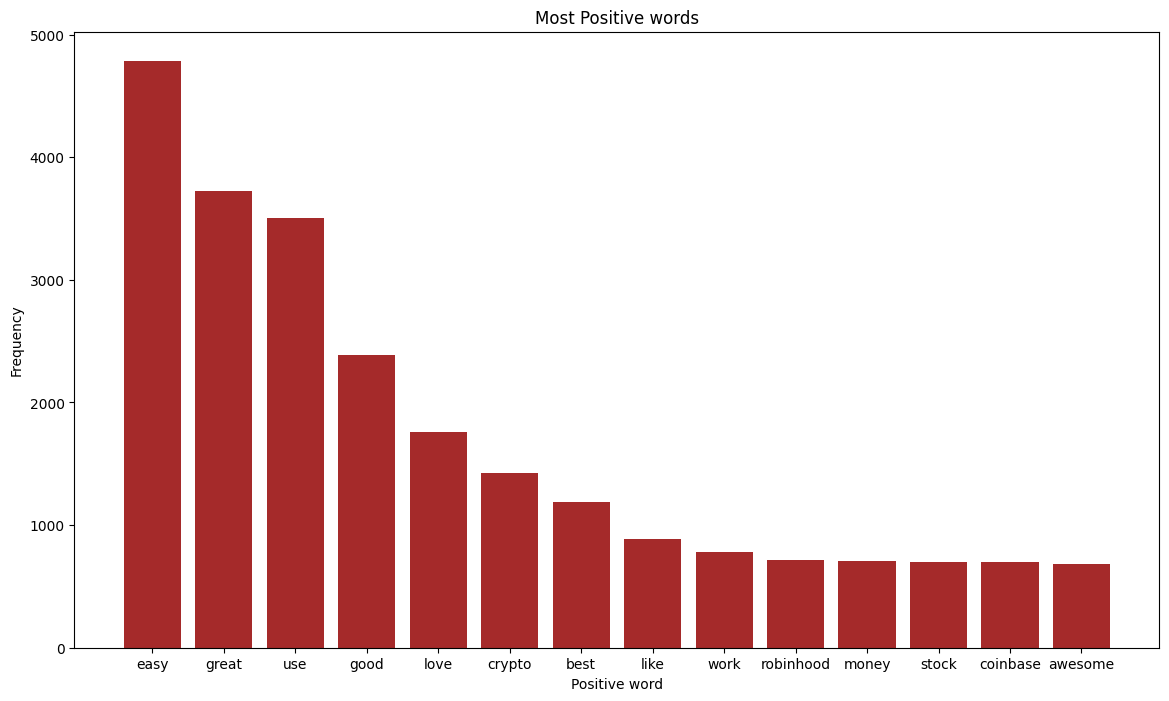

In [47]:
plt.figure(figsize=(14,8))
plt.bar(P,CNT,color='brown')
plt.title('Most Positive words')
plt.xlabel('Positive word')
plt.ylabel('Frequency')
plt.show()

In [48]:
data1 = data[(data['score']==1)]
corp1 = data1['content'].values
tokn = Tokenizer(num_words=250, split=' ')
tokn.fit_on_texts(data1['content'].values)
for n in range(1,15):
    N.append(tokn.index_word[n])

In [49]:
for word in N:
    CNT1.append(tokn.word_counts[word])

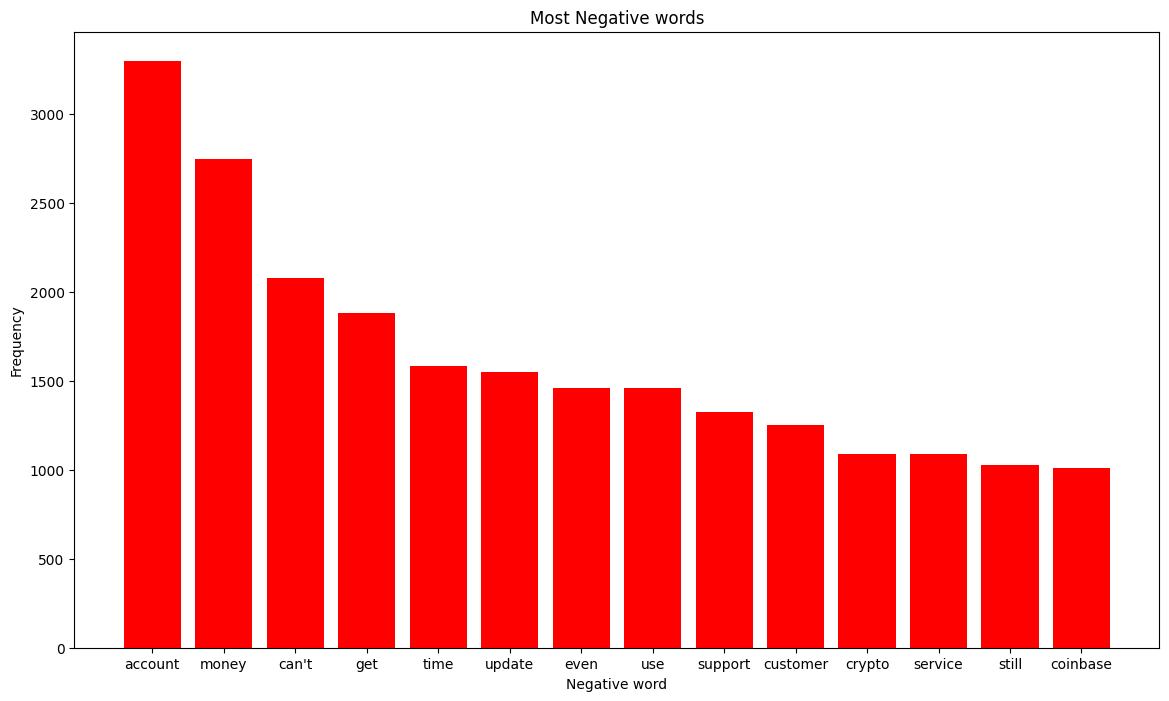

In [50]:
plt.figure(figsize=(14,8))
plt.bar(N,CNT1,color='red')
plt.title('Most Negative words')
plt.xlabel('Negative word')
plt.ylabel('Frequency')
plt.show()

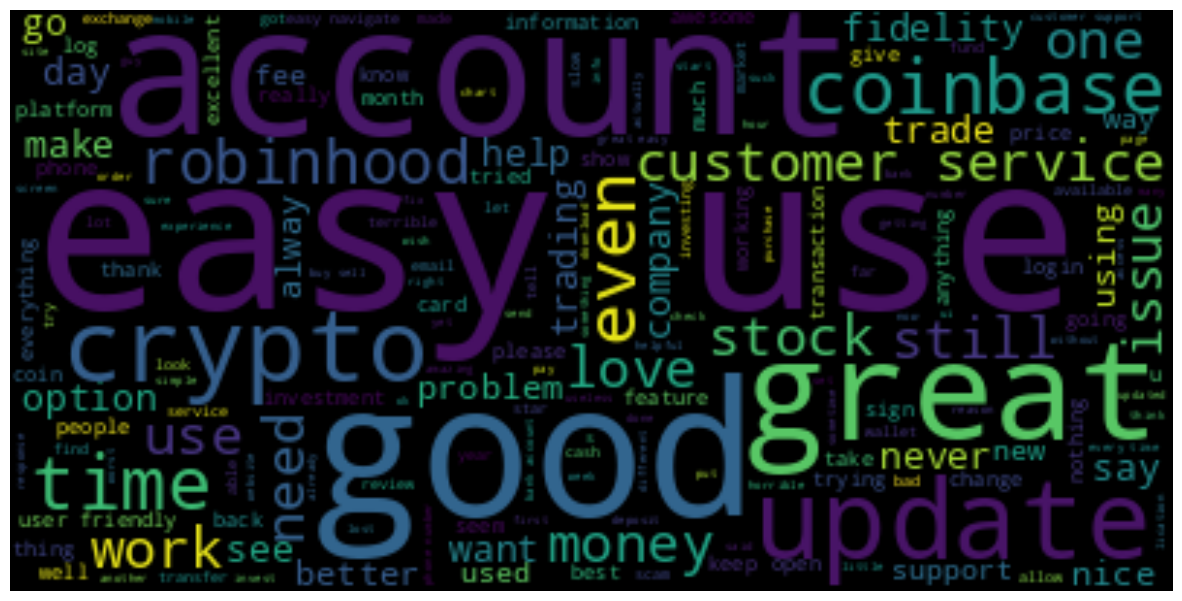

In [51]:
#Frequency of positive words is much more than frequency of Negative words.
#Lets build word cloud on complete data for its verification.
#Lets create word cloud of data to analyse most commonly used words.
common_words=''
for i in data.content:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
A = wordcloud.WordCloud().generate(common_words)
plt.figure(figsize=(15,12))
plt.imshow(A, interpolation='bilinear')
plt.axis("off")
plt.show()

In [54]:
#convert date to datetime format for time based analysis
data['New_date'] = pd.to_datetime(data['at'],format = "%Y-%m-%d %H:%M:%S")

In [55]:
data['Month'] = data['New_date'].dt.month_name()
data['Year'] = data['New_date'].dt.year
data['date'] = data['New_date'].dt.day
data['Hour'] = data['New_date'].dt.hour
data['Minutes'] = data['New_date'].dt.minute
data['Seconds'] = data['New_date'].dt.second

In [56]:
#Data grouped by app and score to analyse each app and its score count
data.groupby(['app','score']).count()
A = data.groupby(['app','score']).count().reset_index()
A['count'] = A['Year']
A = A.drop(['userName','content','thumbsUpCount','at','New_date','Month','Year','date','Hour','Minutes','Seconds'],axis=1)

In [58]:
# Calculate the sum of scores for each app
Fidelity_Crypto_total = A.iloc[0:5]['count'].sum()
Crypto_com_total = A.iloc[5:10]['count'].sum()
Robinhood_Crypto_total = A.iloc[10:15]['count'].sum()
Coinbase_total = A.iloc[15:20]['count'].sum()

# Calculate the percentage for each app
A.loc[A['app'] == 'com.fidelity.android', 'Percentage'] = (A['count'] / Fidelity_Crypto_total) * 100
A.loc[A['app'] == 'co.mona.android', 'Percentage'] = (A['count'] / Crypto_com_total) * 100
A.loc[A['app'] == 'com.robinhood.android', 'Percentage'] = (A['count'] / Robinhood_Crypto_total) * 100
A.loc[A['app'] == 'com.coinbase.android', 'Percentage'] = (A['count'] / Coinbase_total) * 100


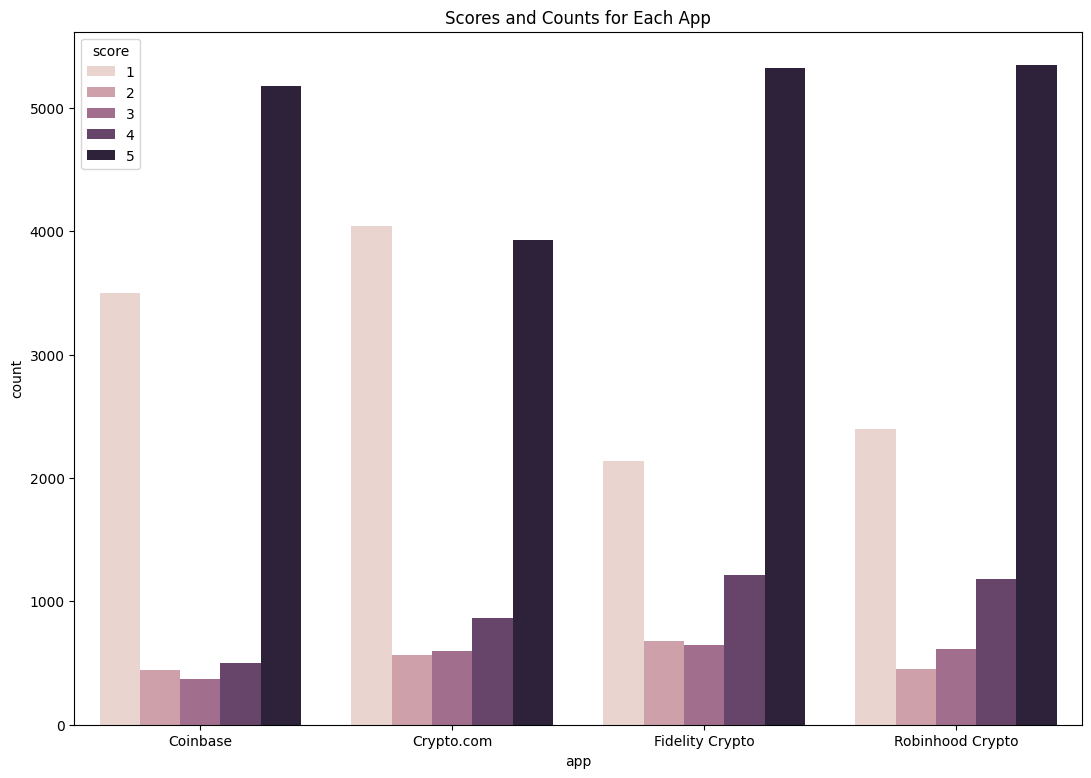

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(13, 9))

# Create the bar plot
sns.barplot(x='app', y='count', hue='score', data=A)

# Set the title of the plot
plt.title('Scores and Counts for Each App')

# Show the plot
plt.show()


Rule-Based Methods

In [62]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


In [64]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize Vader Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to get sentiment scores using Vader
def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores  # Return all sentiment scores

# Apply Vader Sentiment Analysis to each review
data['vader_scores'] = data['content'].apply(get_vader_sentiment)

# Print the sentiment scores for the first few reviews
for index, row in data.head().iterrows():
    print("Review:", row['content'])
    print("Sentiment Scores:", row['vader_scores'])
    print()


Review: Very easy to use the sire
Sentiment Scores: {'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compound': 0.4927}

Review: Top tier
Sentiment Scores: {'neg': 0.0, 'neu': 0.357, 'pos': 0.643, 'compound': 0.2023}

Review: Spent almost hour with technical support with no fix. Watchlist update but won't stream & G/L in position doesn't work right and many more issues.
Sentiment Scores: {'neg': 0.06, 'neu': 0.87, 'pos': 0.07, 'compound': 0.0644}

Review: Works good
Sentiment Scores: {'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'compound': 0.4404}

Review: Easy to use, and works consistently.
Sentiment Scores: {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'compound': 0.4404}



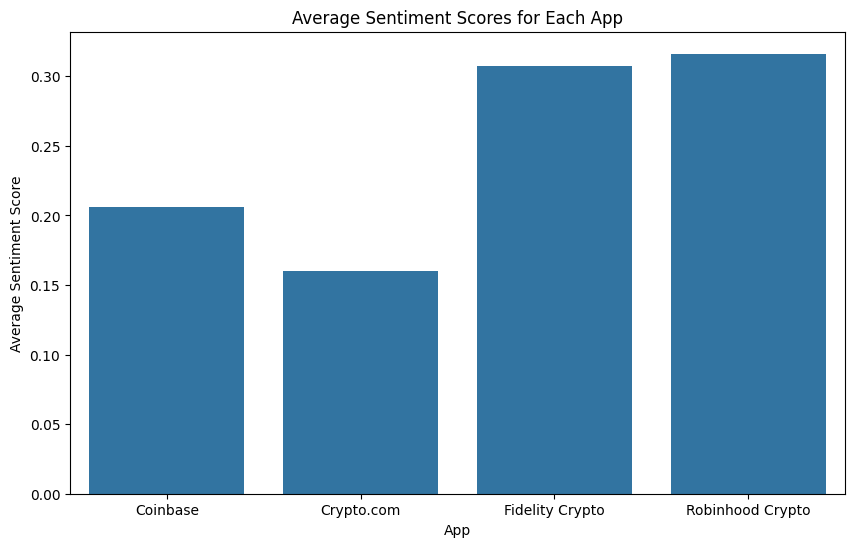

<Figure size 1000x600 with 0 Axes>

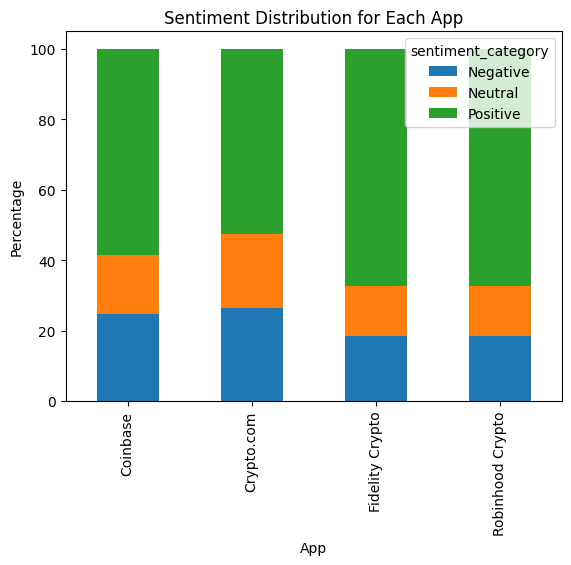

In [67]:
from wordcloud import WordCloud

# Extract the sentiment score components
data['vader_compound'] = [score['compound'] for score in data['vader_scores']]
data['vader_positive'] = [score['pos'] for score in data['vader_scores']]
data['vader_negative'] = [score['neg'] for score in data['vader_scores']]
data['vader_neutral'] = [score['neu'] for score in data['vader_scores']]

# Display the first few rows of the updated DataFrame
data.head()

# Calculate the average sentiment scores for each app
sentiment_scores = data.groupby('app')['vader_compound'].mean()

# Create a bar plot to visualize the average sentiment scores
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_scores.index, y=sentiment_scores.values)
plt.title('Average Sentiment Scores for Each App')
plt.xlabel('App')
plt.ylabel('Average Sentiment Score')
plt.show()

# Create a function to classify sentiment based on Vader score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the classification function to the 'vader_compound' column
data['sentiment_category'] = data['vader_compound'].apply(classify_sentiment)

# Display the first few rows of the updated DataFrame
data.head()

# Calculate the percentage of positive, negative, and neutral reviews for each app
sentiment_counts = data.groupby(['app', 'sentiment_category']).size().unstack()
sentiment_percentages = sentiment_counts.apply(lambda x: x / x.sum() * 100, axis=1)

# Create a bar chart to visualize the sentiment distribution for each app
plt.figure(figsize=(10, 6))
sentiment_percentages.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution for Each App')
plt.xlabel('App')
plt.ylabel('Percentage')
plt.show()



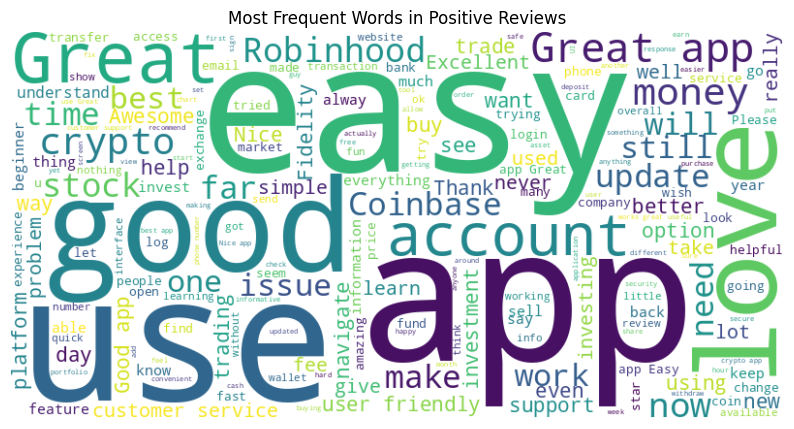

In [70]:
# Create a word cloud for positive and negative reviews
positive_words = ' '.join(data[data['sentiment_category'] == 'Positive']['content'])
negative_words = ' '.join(data[data['sentiment_category'] == 'Negative']['content'])

# Create a word cloud for positive words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Positive Reviews')
plt.show()



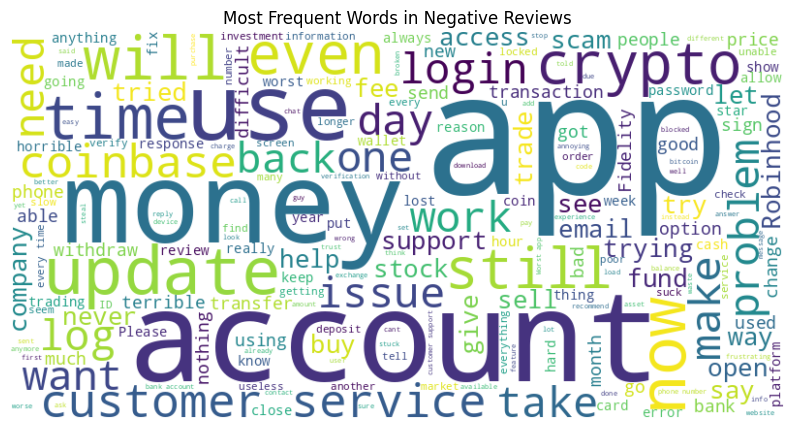

In [71]:
# Create a word cloud for negative words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Negative Reviews')
plt.show()

In [77]:
# Save the sentiment category into the data
data['sentiment_category'] = data['vader_compound'].apply(classify_sentiment)

# Display the first few rows of the updated DataFrame
print(data.head())

# Save the updated DataFrame to a CSV file
data.to_csv('sentiment_analysis_results.csv', index=False)


                                             content  score  \
0                          Very easy to use the sire      5   
1                                           Top tier      5   
2  Spent almost hour with technical support with ...      1   
3                                         Works good      4   
4               Easy to use, and works consistently.      5   

                      userName  thumbsUpCount                  at  \
0                   David Beil              0 2024-02-07 15:50:15   
1  Paula Grooveparlortv Harris              0 2024-02-07 15:44:55   
2                 Roger Duvall              0 2024-02-07 15:07:39   
3           michael pietschker              0 2024-02-07 14:55:29   
4              Thomas Anderson              0 2024-02-07 14:49:03   

               app  review_length            New_date     Month  Year  ...  \
0  Fidelity Crypto             25 2024-02-07 15:50:15  February  2024  ...   
1  Fidelity Crypto              8 2024-02-07 15:44

In [78]:
#  check column

print(data.columns)


Index(['content', 'score', 'userName', 'thumbsUpCount', 'at', 'app',
       'review_length', 'New_date', 'Month', 'Year', 'date', 'Hour', 'Minutes',
       'Seconds', 'vader_score', 'vader_scores', 'vader_compound',
       'vader_positive', 'vader_negative', 'vader_neutral',
       'sentiment_category'],
      dtype='object')


**Recurrent Neural Network (RNN) model**

In [76]:
#  structure of your DataFrame data

print(data.columns)


Index(['content', 'score', 'userName', 'thumbsUpCount', 'at', 'app',
       'review_length', 'New_date', 'Month', 'Year', 'date', 'Hour', 'Minutes',
       'Seconds', 'vader_score', 'vader_scores', 'vader_compound',
       'vader_positive', 'vader_negative', 'vader_neutral',
       'sentiment_category'],
      dtype='object')


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
# Encode sentiment categories into numerical values
data['sentiment_category'] = data['sentiment_category'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})

# Convert the encoded sentiment categories to numpy array
y_train = np.array(data['sentiment_category'])

# Train the model
model.fit(X_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['content'])
X_seq = tokenizer.texts_to_sequences(data['content'])

# Pad sequences to ensure uniform length
max_seq_length = max([len(seq) for seq in X_seq])
X_pad = pad_sequences(X_seq, maxlen=max_seq_length, padding='post')

# Define the RNN model architecture
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_seq_length),
    LSTM(units=128),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_pad, data['sentiment_category'], epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_pad, data['sentiment_category'])
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
 277/1000 [=======>......................] - ETA: 6:28 - loss: -89.0511 - accuracy: 0.1590

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
